# Making a general helping classifier


Functions needed: 

def get_initial_classifier(full_train_X,full_train_y, clf, param_grid):
    return clf 
    
def get_helping_classifier(X_train, y_train, X_val, y_val, clf, param_grid): 
    return clf_help
    
def filter_test_set(clf_help, X_test, y_test)
    return X_test, y_test

In [73]:
import numpy as np
import pandas as pd
import sys
import os
module_path = os.path.abspath(os.path.join('../..'))
sys.path.insert(1, module_path + '/src/')


import warnings
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning, FitFailedWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FitFailedWarning)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import utility
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 10, weight = 1000)
font_small = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 8, weight = 1000)



def get_dataset_partitions(X, y):
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size = 0.5, random_state = 1)
    return (X_train_full, y_train_full), (X_train, y_train), (X_val, y_val), (X_test, y_test)


def get_initial_classifier(X_train_full,y_train_full, clf, grid, no_grid_search = False):
    grid_cv=GridSearchCV(clf,grid,cv=5)
    grid_cv.fit(X_train_full,y_train_full)
    return grid_cv.best_estimator_

def get_helping_classifier(X_train, y_train, X_val, y_val, clf, grid , no_grid_search = False):
    new_X = X_val
    if no_grid_search:
        clf.fit(X_train, y_train)
    else:
        grid_cv=GridSearchCV(clf,grid,cv=5)
        grid_cv.fit(X_train,y_train)
        clf = grid_cv.best_estimator_
        
    y_pred = clf.predict(X_val)
    new_y = pd.Series(np.hstack([y_pred != y_val]))
    
    if no_grid_search:
        clf.fit(new_X,new_y)
    else:
        clf = grid_cv.fit(new_X,new_y)
    return clf
    
def filter_test_set(clf_help, X_test, y_test):
    y_pred = clf_help.predict(X_test)
    to_del = np.where(y_pred == True)[0]
    X_test = X_test.reset_index(drop = True)
    y_test = y_test.reset_index(drop = True)
    X_test_new = X_test[~X_test.index.isin(to_del)]
    y_test_new = y_test[~y_test.index.isin(to_del)]
    return X_test_new, y_test_new

def plot_cm(clf, X_test, y_test, class_names, color_index = 2):
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    colors = ["#F94144", "#F3722C", '#F8961E', '#F9C74F','#90BE6D', '#43AA8B','#577590']

    font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 10, weight = 1000)

    colors_2 = ['#FFFFFF', colors[color_index]]
    cmap_name = 'my colormap'
    font_small = FontProperties(fname =  module_path + '/src/visualization/CharterRegular.ttf', size = 6, weight = 1000)

    cm_map = LinearSegmentedColormap.from_list(cmap_name, colors_2)


    f, ax = plt.subplots(1,1) # 1 x 1 array , can also be any other size
    f.set_size_inches(5, 5)

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm, annot=True,
                fmt='.2%', cmap=cm_map, xticklabels=class_names,yticklabels=class_names )
    cbar = ax.collections[0].colorbar
    for label in ax.get_yticklabels() :
        label.set_fontproperties(font_small)
    for label in ax.get_xticklabels() :
        label.set_fontproperties(font_small)
    ax.set_ylabel('True Label', fontproperties = font)
    ax.set_xlabel('Predicted Label', fontproperties = font)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)

    for child in ax.get_children():
        if isinstance(child, matplotlib.text.Text):
            child.set_fontproperties(font)
    for l in cbar.ax.yaxis.get_ticklabels():
        l.set_fontproperties(font_small)


def print_and_plot_to_compare(X_test, y_test, X_test_2, y_test_2, clf, class_names):
    y_pred = clf.predict(X_test)
    print(f'Accuracy score for the initial classification: {accuracy_score(y_test, y_pred)} ')
    print('Confusion matrix, initial classification: ')
    plot_cm(clf, X_test, y_test, class_names)
    
    y_pred_2 = clf.predict(X_test_2)
    print(f'Accuracy score for the double classification: {accuracy_score(y_test_2, y_pred_2)} ')
    print('Confusion matrix, double classification: ')
    plot_cm(clf, X_test_2, y_test_2, class_names, color_index = 5)
    

# Lung sound dataset

In [65]:
X, y =  utility.get_X_y('noDecomp', feature_type = 'all')
(X_train_full, y_train_full), (X_train, y_train), (X_val, y_val), (X_test, y_test) = get_dataset_partitions(X,y)

## K-nn

Accuracy score for the initial classification: 0.7933753943217665 
Confusion matrix, initial classification: 
Accuracy score for the double classification: 0.792604501607717 
Confusion matrix, double classification: 


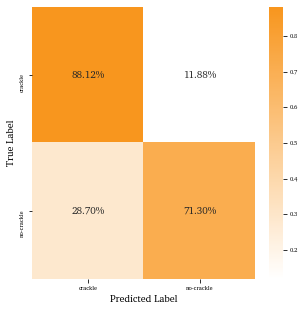

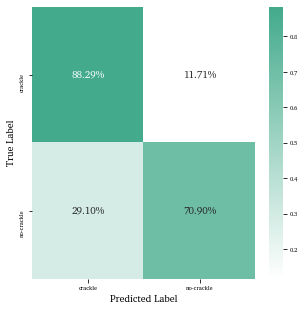

In [66]:
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
grid = dict(n_neighbors = k_range, weights = weight_options)

'''

clf_full = KNeighborsClassifier(n_neighbors=4, weights='distance')
clf_helper = KNeighborsClassifier(n_neighbors=14)
clf_full = get_initial_classifier(X_train_full, y_train_full, clf_full, grid, True)
clf_helper = get_helping_classifier(X_train, y_train, X_val, y_val, clf_helper, grid, True)

'''
clf = KNeighborsClassifier()
clf_full = get_initial_classifier(X_train_full, y_train_full, clf, grid)
clf_helper = get_helping_classifier(X_train, y_train, X_val, y_val, clf, grid)


X_test_2, y_test_2 = filter_test_set(clf_helper, X_test, y_test)
print_and_plot_to_compare(X_test, y_test, X_test_2, y_test_2, clf_full, ['crackle', 'no-crackle'])


## Logistic Regression

Accuracy score for the initial classification: 0.6971608832807571 
Confusion matrix, initial classification: 
Accuracy score for the double classification: 0.6971608832807571 
Confusion matrix, double classification: 


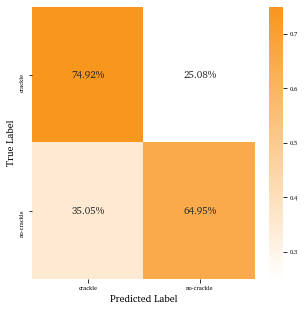

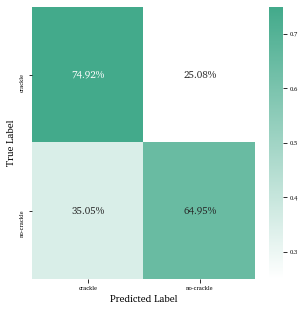

In [67]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
clf=LogisticRegression()

clf_full = get_initial_classifier(X_train_full, y_train_full, clf, grid)
clf_helper = get_helping_classifier(X_train, y_train, X_val, y_val, clf, grid)

X_test_2, y_test_2 = filter_test_set(clf_helper, X_test, y_test)
print_and_plot_to_compare(X_test, y_test, X_test_2, y_test_2, clf_full, ['crackle', 'no-crackle'])

# Arrow dataset

In [68]:
from sktime.datasets import load_arrow_head, load_basic_motions
from sktime.transformations.panel.catch22_features import Catch22

class_names = ['Avonlea', 'Clovis','Mix']
X, y = load_arrow_head(return_X_y=True)
c22f = Catch22()
c22f.fit(X, y)
X = c22f.transform(X)
(X_train_full, y_train_full), (X_train, y_train), (X_val, y_val), (X_test, y_test) = get_dataset_partitions(X,y)

class_names = ['Avonlea', 'Clovis','Mix']

## K-nn

Accuracy score for the initial classification: 0.8837209302325582 
Confusion matrix, initial classification: 
Accuracy score for the double classification: 0.9142857142857143 
Confusion matrix, double classification: 


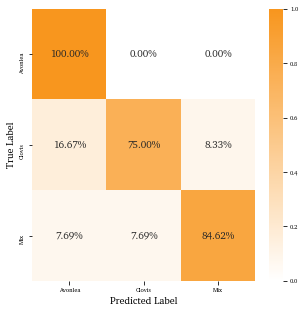

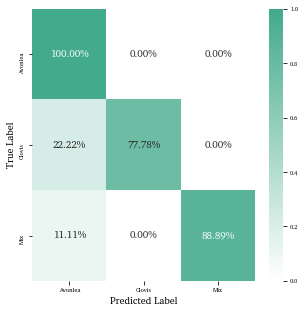

In [69]:
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
grid = dict(n_neighbors = k_range, weights = weight_options)
clf = KNeighborsClassifier()

clf_full = get_initial_classifier(X_train_full, y_train_full, clf, grid)
clf_helper = get_helping_classifier(X_train, y_train, X_val, y_val, clf, grid)

X_test_2, y_test_2 = filter_test_set(clf_helper, X_test, y_test)
print_and_plot_to_compare(X_test, y_test, X_test_2, y_test_2, clf_full, class_names)

## Logistic Regression

Accuracy score for the initial classification: 0.6976744186046512 
Confusion matrix, initial classification: 
Accuracy score for the double classification: 0.7142857142857143 
Confusion matrix, double classification: 


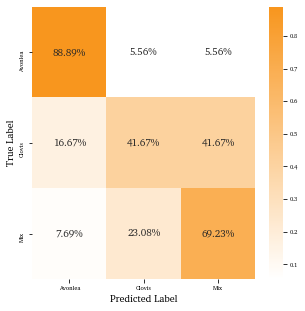

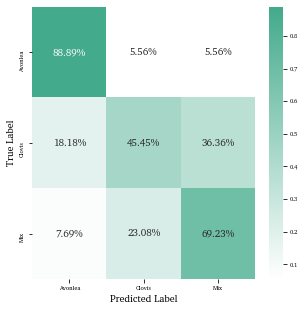

In [70]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
clf=LogisticRegression()

clf_full = get_initial_classifier(X_train_full, y_train_full, clf, grid)
clf_helper = get_helping_classifier(X_train, y_train, X_val, y_val, clf, grid)

X_test_2, y_test_2 = filter_test_set(clf_helper, X_test, y_test)
print_and_plot_to_compare(X_test, y_test, X_test_2, y_test_2, clf_full,class_names)

# Gunpoint dataset



In [75]:
from sktime.datasets import load_gunpoint

X, y = load_gunpoint(return_X_y=True)
c22f = Catch22()
c22f.fit(X, y)
X = c22f.transform(X)
(X_train_full, y_train_full), (X_train, y_train), (X_val, y_val), (X_test, y_test) = get_dataset_partitions(X,y)

class_names = ['Gun-Draw', 'Point']

## K-nn

Accuracy score for the initial classification: 0.825 
Confusion matrix, initial classification: 
Accuracy score for the double classification: 0.8285714285714286 
Confusion matrix, double classification: 


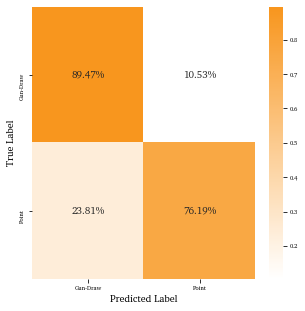

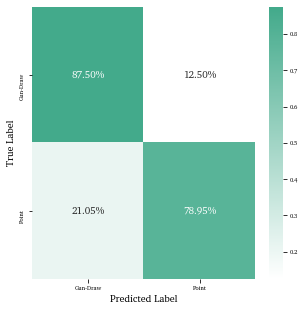

In [76]:
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
grid = dict(n_neighbors = k_range, weights = weight_options)
clf = KNeighborsClassifier()

clf_full = get_initial_classifier(X_train_full, y_train_full, clf, grid)
clf_helper = get_helping_classifier(X_train, y_train, X_val, y_val, clf, grid)

X_test_2, y_test_2 = filter_test_set(clf_helper, X_test, y_test)
print_and_plot_to_compare(X_test, y_test, X_test_2, y_test_2, clf_full, class_names)

## Logistic regression

Accuracy score for the initial classification: 0.95 
Confusion matrix, initial classification: 
Accuracy score for the double classification: 0.9444444444444444 
Confusion matrix, double classification: 


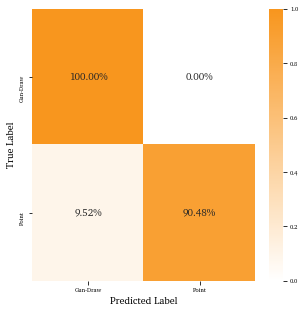

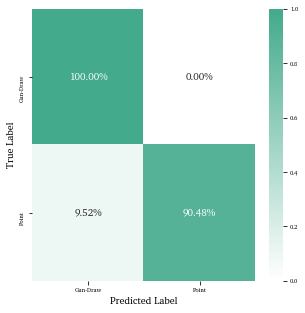

In [77]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
clf=LogisticRegression()

clf_full = get_initial_classifier(X_train_full, y_train_full, clf, grid)
clf_helper = get_helping_classifier(X_train, y_train, X_val, y_val, clf, grid)

X_test_2, y_test_2 = filter_test_set(clf_helper, X_test, y_test)
print_and_plot_to_compare(X_test, y_test, X_test_2, y_test_2, clf_full, class_names)

# Osuleaf dataset

In [80]:
from sktime.datasets import load_osuleaf

X, y = load_osuleaf(return_X_y=True)
c22f = Catch22()
c22f.fit(X, y)
X = c22f.transform(X)
(X_train_full, y_train_full), (X_train, y_train), (X_val, y_val), (X_test, y_test) = get_dataset_partitions(X,y)

class_names = ['Acer Circinatum', 'Acer Glabrum', 'Acer Macrophyllum', 'Acer Negundo', 'Quercus Garryanaand' , 'Quercus Kelloggii' ]

## K-nn

Accuracy score for the initial classification: 0.6404494382022472 
Confusion matrix, initial classification: 
Accuracy score for the double classification: 0.6666666666666666 
Confusion matrix, double classification: 


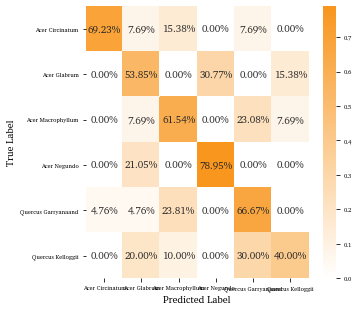

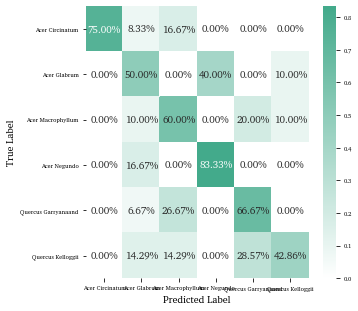

In [81]:
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
grid = dict(n_neighbors = k_range, weights = weight_options)
clf = KNeighborsClassifier()

clf_full = get_initial_classifier(X_train_full, y_train_full, clf, grid)
clf_helper = get_helping_classifier(X_train, y_train, X_val, y_val, clf, grid)

X_test_2, y_test_2 = filter_test_set(clf_helper, X_test, y_test)
print_and_plot_to_compare(X_test, y_test, X_test_2, y_test_2, clf_full, class_names)

## Logistic regression

Accuracy score for the initial classification: 0.5617977528089888 
Confusion matrix, initial classification: 
Accuracy score for the double classification: 0.6222222222222222 
Confusion matrix, double classification: 


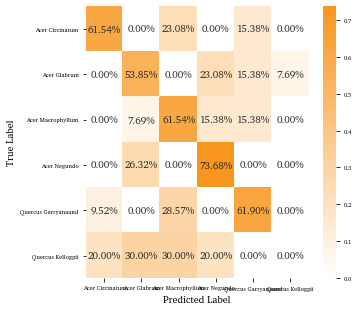

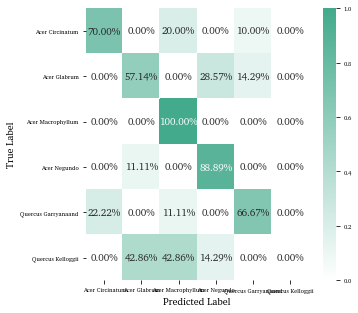

In [82]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
clf=LogisticRegression()

clf_full = get_initial_classifier(X_train_full, y_train_full, clf, grid)
clf_helper = get_helping_classifier(X_train, y_train, X_val, y_val, clf, grid)

X_test_2, y_test_2 = filter_test_set(clf_helper, X_test, y_test)
print_and_plot_to_compare(X_test, y_test, X_test_2, y_test_2, clf_full, class_names)

# ECG 4000

In [119]:
from sktime.datasets import load_UCR_UEA_dataset

X, y = load_UCR_UEA_dataset('ECG5000', return_X_y=True)


c22f = Catch22()
c22f.fit(X, y)
X = c22f.transform(X)
(X_train_full, y_train_full), (X_train, y_train), (X_val, y_val), (X_test, y_test) = get_dataset_partitions(X,y)

class_names = ['0', '1', '2', '3', '4' ]

## K-nn

Accuracy score for the initial classification: 0.929 
Confusion matrix, initial classification: 
Accuracy score for the double classification: 0.9394250513347022 
Confusion matrix, double classification: 


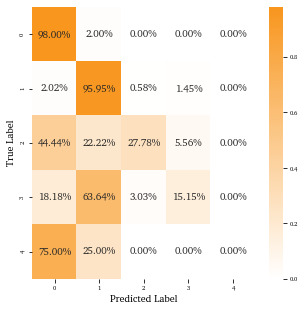

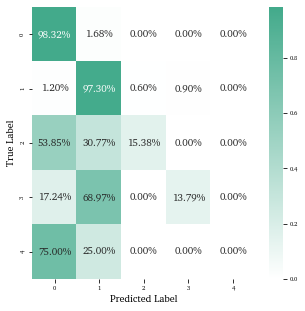

In [120]:
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
grid = dict(n_neighbors = k_range, weights = weight_options)
clf = KNeighborsClassifier()

clf_full = get_initial_classifier(X_train_full, y_train_full, clf, grid)
clf_helper = get_helping_classifier(X_train, y_train, X_val, y_val, clf, grid)

X_test_2, y_test_2 = filter_test_set(clf_helper, X_test, y_test)
print_and_plot_to_compare(X_test, y_test, X_test_2, y_test_2, clf_full, class_names)

## Logistic regression

Accuracy score for the initial classification: 0.893 
Confusion matrix, initial classification: 
Accuracy score for the double classification: 0.8994871794871795 
Confusion matrix, double classification: 


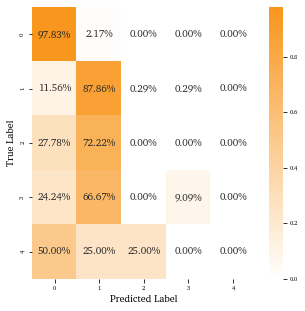

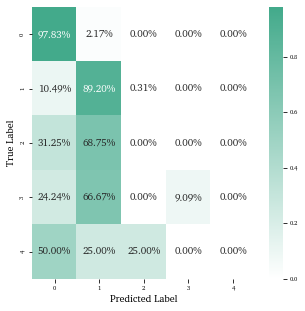

In [121]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
clf=LogisticRegression()

clf_full = get_initial_classifier(X_train_full, y_train_full, clf, grid)
clf_helper = get_helping_classifier(X_train, y_train, X_val, y_val, clf, grid)

X_test_2, y_test_2 = filter_test_set(clf_helper, X_test, y_test)
print_and_plot_to_compare(X_test, y_test, X_test_2, y_test_2, clf_full, class_names)

# ECG200

In [124]:
from sktime.datasets import load_UCR_UEA_dataset

X, y = load_UCR_UEA_dataset('ECG200', return_X_y=True)


c22f = Catch22()
c22f.fit(X, y)
X = c22f.transform(X)
(X_train_full, y_train_full), (X_train, y_train), (X_val, y_val), (X_test, y_test) = get_dataset_partitions(X,y)

class_names = ['normal','myocardial']

## K-NN

Accuracy score for the initial classification: 0.725 
Confusion matrix, initial classification: 
Accuracy score for the double classification: 0.7058823529411765 
Confusion matrix, double classification: 


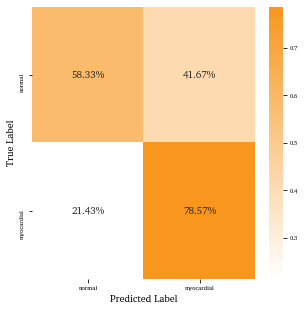

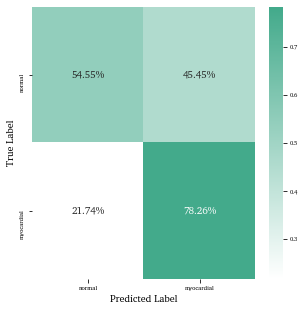

In [125]:
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
grid = dict(n_neighbors = k_range, weights = weight_options)
clf = KNeighborsClassifier()

clf_full = get_initial_classifier(X_train_full, y_train_full, clf, grid)
clf_helper = get_helping_classifier(X_train, y_train, X_val, y_val, clf, grid)

X_test_2, y_test_2 = filter_test_set(clf_helper, X_test, y_test)
print_and_plot_to_compare(X_test, y_test, X_test_2, y_test_2, clf_full, class_names)

## Logistic regression

Accuracy score for the initial classification: 0.75 
Confusion matrix, initial classification: 
Accuracy score for the double classification: 0.76 
Confusion matrix, double classification: 


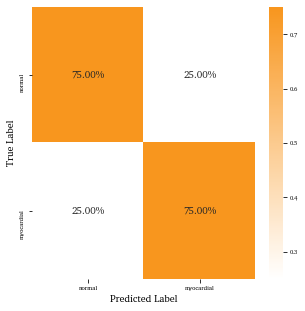

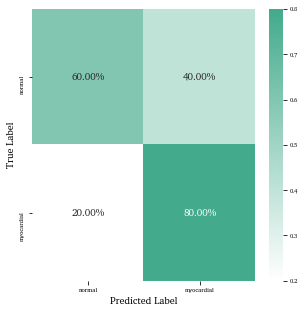

In [126]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
clf=LogisticRegression()

clf_full = get_initial_classifier(X_train_full, y_train_full, clf, grid)
clf_helper = get_helping_classifier(X_train, y_train, X_val, y_val, clf, grid)

X_test_2, y_test_2 = filter_test_set(clf_helper, X_test, y_test)
print_and_plot_to_compare(X_test, y_test, X_test_2, y_test_2, clf_full, class_names)

# EEG (MotorImagry)

In [127]:
from sktime.datasets import load_UCR_UEA_dataset

X, y = load_UCR_UEA_dataset('MotorImagery', return_X_y=True)


c22f = Catch22()
c22f.fit(X, y)
X = c22f.transform(X)
(X_train_full, y_train_full), (X_train, y_train), (X_val, y_val), (X_test, y_test) = get_dataset_partitions(X,y)


KeyboardInterrupt: 

## K-NN

In [ ]:
class_names = ['left small finger', 'tongue']

k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
grid = dict(n_neighbors = k_range, weights = weight_options)
clf = KNeighborsClassifier()

clf_full = get_initial_classifier(X_train_full, y_train_full, clf, grid)
clf_helper = get_helping_classifier(X_train, y_train, X_val, y_val, clf, grid)

X_test_2, y_test_2 = filter_test_set(clf_helper, X_test, y_test)
print_and_plot_to_compare(X_test, y_test, X_test_2, y_test_2, clf_full, class_names)

## Logistic regression

In [ ]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
clf=LogisticRegression()

clf_full = get_initial_classifier(X_train_full, y_train_full, clf, grid)
clf_helper = get_helping_classifier(X_train, y_train, X_val, y_val, clf, grid)

X_test_2, y_test_2 = filter_test_set(clf_helper, X_test, y_test)
print_and_plot_to_compare(X_test, y_test, X_test_2, y_test_2, clf_full, class_names)